In [1]:
using Gen, Plots, Images, Colors

In [64]:
# Global vars
IMG_SIZE = 100;

## Rendering of a scene

In [65]:
# Drawing utilities

# colors
color_map = Dict("red" => [1.0, 0.0, 0.0], "yellow" => [1.0, 1.0, 0.0], "green" => [0.0, 1.0, 0.0])

# shapes
function draw_square!(img, center, size, color)
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            img[ny, nx] = color
        end
    end
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                img[ny, nx] = color
            end
        end
    end
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [233]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false)
    img = fill([1.0,1.0,1.0], IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        shape_map[shape](img, center, 10, color_map[color])
    end
    if show_img
        display(to_display_img(img))
    end
    return img
    end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    return render(objects, show_img)
    end

render_trace (generic function with 2 methods)

## Generative model for a scene

In [67]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(3)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle", "star"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,3)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#294", Bool[], false)

In [68]:
# Generative for scoring
@gen function render_model()
    latents ~ scene()
    x = render(latents)
    obs ~ obs_mixture(x)
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#295", Bool[], false)

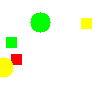

In [7]:
# Example usage
render_trace(Gen.simulate(scene, ()), true);

In [8]:
foo = render(scene())

100×100 Matrix{Vector{Float64}}:
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]  …  [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]  …  [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]  …  [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]     [1.0, 1.0, 1.0]  [1.0, 1.0, 1.0]
 ⋮                                 ⋱        

## Scoring sampled scenes

In [276]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Vector{Float64}}} end

function Gen.random(::ObservationMixture, X::Matrix{Vector{Float64}})
    # Throw an error since just a scoring fn
    return X
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Vector{Float64}},
        X::Matrix{Vector{Float64}})

    blank = fill([1.0,1.0,1.0], size(X))
    input_non_background_mask = .!(X .== blank)

    obs_non_background = Y[input_non_background_mask]
    input_non_background = X[input_non_background_mask]
    # Should also check the color, currently just checking if pixel thats non-white
    # Should also fix so non just normalizing based on the input -- problem is input is a subset of the full thing
    intersection = sum(obs_non_background .== input_non_background)
    normalizer = sum(input_non_background_mask)
    return log(intersection) - log(normalizer)
end

(o::ObservationMixture)(arg) = Gen.random(o, arg)
# (o::ObservationMixture).logpdf(args...) = Gen.logpdf(o, args)

In [286]:
obs_mixture = ObservationMixture()
foo = render(scene())
foo2 = render(scene())
_ = obs_mixture(foo)
print("Sanity checking score fn: ", exp(logpdf(obs_mixture, foo, foo)))

Sanity checking score fn: 1.0

## Inference procedure

In [287]:
# Inference display utils
function render_samples(traces, log_weights)
    normalized_log_weights = log_weights .- logsumexp(log_weights)
    sample_weights = exp.(normalized_log_weights)
    cum_sampled_scene = render(traces[1][:latents]) * sample_weights[1]
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * sample_weights[i]
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

render_samples (generic function with 1 method)

In [288]:
# Example inference procedure
function do_inference(model, constraints, num_iter)
    
    # # Create a choice map that maps model addresses (:y, i)
    # # to observed values ys[i]. We leave :slope and :intercept
    # # unconstrained, because we want them to be inferred.
    # observations = Gen.choicemap()
    # for (i, y) in enumerate(ys)
    #     observations[(:y, i)] = y
    # end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (traces, weights, _) = Gen.importance_sampling(model, (), constraints, num_iter);
    return traces, weights
end;

In [289]:
obs = render(scene());
constraints = Gen.choicemap()
constraints[:obs] = obs
traces, weights = do_inference(render_model, constraints, 10000);

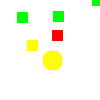

In [290]:
to_display_img(obs)

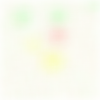

In [291]:
to_display_img(render_samples(traces, weights))

### Experimenting w/ constraints

In [298]:
obs_trace = simulate(scene, ())
obs = render_trace(obs_trace)
obs_n_objects = obs_trace[:n_objects]

constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_n_objects
traces, weights = do_inference(render_model, constraints, 10000);

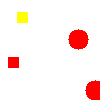

In [299]:
to_display_img(obs)

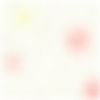

In [300]:
to_display_img(render_samples(traces, weights))

## Particle Filtering

In [ ]:
function particle_filter(num_particles::Int, constraints, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    
    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;